# **Loading the pertinent libraries**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import get_dummies
from google.colab import files
import io
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from scipy import stats
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import keras
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import probplot
from pandas.plotting import bootstrap_plot


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Uploading the train and test data set**


We upload the files to google colaboratory



In [3]:
uploaded = files.upload()
uploaded1 = files.upload()

Saving Data_Train.xlsx to Data_Train (3).xlsx


Saving Data_Test.xlsx to Data_Test (2).xlsx


In [0]:
dfTest = pd.read_excel(io.BytesIO(uploaded1['Data_Test.xlsx'])) #Loading the test dataset
dfTrain = pd.read_excel(io.BytesIO(uploaded['Data_Train.xlsx'])) #Loading the train dataset

We drop the nan values from both the train and test data set provided. For cleaning the data and feature extraction, we join the train and test datasets. Also, in the price column we include a high value, so that the sets can be separated later when needed.

In [5]:

dfTest.dropna(inplace = True)
dfTrain.dropna(inplace = True)
dfTest['Price'] = 1e8
dfTest.isnull().any(), dfTrain.isnull().any()

(Name                 False
 Location             False
 Year                 False
 Kilometers_Driven    False
 Fuel_Type            False
 Transmission         False
 Owner_Type           False
 Mileage              False
 Engine               False
 Power                False
 Seats                False
 Price                False
 dtype: bool, Name                 False
 Location             False
 Year                 False
 Kilometers_Driven    False
 Fuel_Type            False
 Transmission         False
 Owner_Type           False
 Mileage              False
 Engine               False
 Power                False
 Seats                False
 Price                False
 dtype: bool)

# **Data cleaning**



We join the test and train sets provided to us, for reasons specified before

In [6]:
frames = [dfTrain, dfTest]
dfCombined = pd.concat(frames)
dfCombined.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [7]:
dfCombined.tail()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
1229,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,100000000.0
1230,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0,100000000.0
1231,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,100000000.0
1232,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0,100000000.0
1233,Mercedes-Benz E-Class 2009-2013 E 220 CDI Avan...,Kochi,2014,72443,Diesel,Automatic,First,10.0 kmpl,2148 CC,170 bhp,5.0,100000000.0


We must keep the indices intact, so we create a separate column for the indices.This is done because, while processing the data, the identity of an individual entry would be lost if the indices aren't preserved, thus rendering the results we obtain by prediction useless.

In [8]:

dfCombined.reset_index(inplace = True)
dfCombined.tail()

,index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
7193,1229,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,100000000.0
7194,1230,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0,100000000.0
7195,1231,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,100000000.0
7196,1232,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0,100000000.0
7197,1233,Mercedes-Benz E-Class 2009-2013 E 220 CDI Avan...,Kochi,2014,72443,Diesel,Automatic,First,10.0 kmpl,2148 CC,170 bhp,5.0,100000000.0


We note that many of these columns having numerical data have a unit associated with it, so we eliminate it. Also, some of the elements in 'Power' column had a 'null' value stored, since that indicates some lapse while collecting data, it would need to be removed.

In [0]:
dfCombined['Mileage'] = dfCombined['Mileage'].apply(lambda x: float(list(x.split(' '))[0]))
dfCombined['Engine'] = dfCombined['Engine'].apply(lambda x: float(list(x.split(' '))[0]))  #Cleaning the data a little bit
dfCombined['Power'] = dfCombined['Power'].apply(lambda x: list(x.split(' '))[0]) #from experience, power has a 'null' string entry
lisNull = [index for index, element in enumerate(dfCombined['Power']) if element == 'null']
dfCombined.drop(lisNull, inplace = True)
dfCombined['Power'] = dfCombined['Power'].astype('float64')

Checking if any null values remain. We must keep checking for null values repeatedly to ensure that while processing, we don't lose any important information from the data.

In [10]:
dfCombined.isnull().any()  


index                False
Name                 False
Location             False
Year                 False
Kilometers_Driven    False
Fuel_Type            False
Transmission         False
Owner_Type           False
Mileage              False
Engine               False
Power                False
Seats                False
Price                False
dtype: bool

# **Exploratory data analysis**

**Analysis of categorical variables**

Note that all analysis is done over the training dataset only. Deriving intuition from the structure of the test data doesn't make sense, as it is something that is available only when the model has been built and deployed.

In [11]:
dfCombined.head()

,index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74


In [12]:
dfToAnalyze = dfCombined[dfCombined['Price']!=1e8]
dfToAnalyze.head()

,index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74


Mumbai        775
Hyderabad     718
Kochi         645
Coimbatore    629
Pune          594
Delhi         545
Kolkata       521
Chennai       476
Jaipur        402
Bangalore     347
Ahmedabad     220
Name: Location, dtype: int64


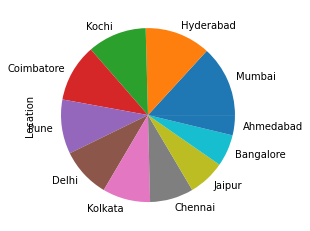

In [13]:
location = dfToAnalyze['Location'].value_counts()
print(location)
location.plot.pie()                                 #Most cars come from Mumbai and Hyderabad

2014    794
2015    740
2016    737
2013    639
2017    586
2012    562
2011    452
2010    333
2018    298
2009    191
2008    162
2007    105
2019    102
2006     66
2005     42
2004     25
2003     14
2002     11
2000      4
2001      4
1998      3
1999      2
Name: Year, dtype: int64


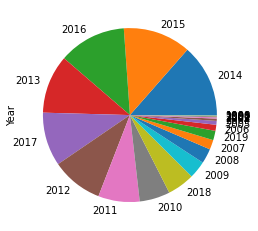

In [14]:
year = dfToAnalyze['Year'].value_counts()
print(year)
year.plot.pie()                      #2014, 22015, 2016 and 2013 shoe the highest numbers of cars dating from thence

Diesel    3152
Petrol    2655
CNG         55
LPG         10
Name: Fuel_Type, dtype: int64


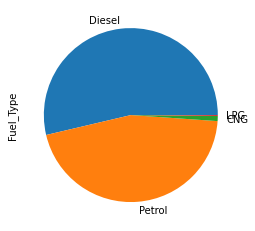

In [15]:
fuelType = dfToAnalyze['Fuel_Type'].value_counts()     #While LPG and petrol are almost the same, LPG having a marginal lead, CNG driven cars are quite low in proportion
print(fuelType)
fuelType.plot.pie()  

Manual       4170
Automatic    1702
Name: Transmission, dtype: int64


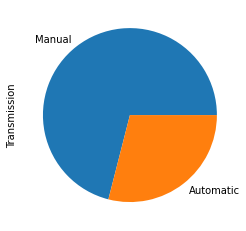

In [16]:
Transmission = dfToAnalyze['Transmission'].value_counts()   #Manual transmission cars are more in number than Automatic transmission cars
print(Transmission)
Transmission.plot.pie()  

First             4839
Second             925
Third              101
Fourth & Above       7
Name: Owner_Type, dtype: int64


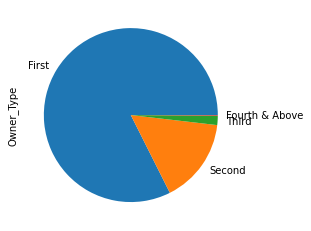

In [17]:
ownerType = dfToAnalyze['Owner_Type'].value_counts()              #Second hand cars are larger in number than Third hand, and above. 
print(ownerType)
ownerType.plot.pie()  

**Interrelation between different categorical variables**

Analysis of how different categorical variables interact can provide additional insights into the data, and how they are related. 

We shall be analysing the relation between the following variables


1.   The dependence of Transmission type, Fuel, and Ownership type over Cities
2.   The dependence of aforementioned variables on the year the car was manufactured





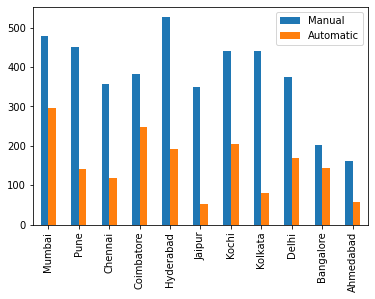

In [18]:
a = []
for i in dfToAnalyze['Location'].unique():
    a.append(dfToAnalyze[dfToAnalyze.Location == i].Transmission.value_counts())
    
a = pd.DataFrame(a)
a.index = dfToAnalyze['Location'].unique()
a.plot.bar()


At almost every location manual type transmission vehicles are more than automatic type transmission vehicles. The disparity though, is highest in Kolkata and the least in Bangalore


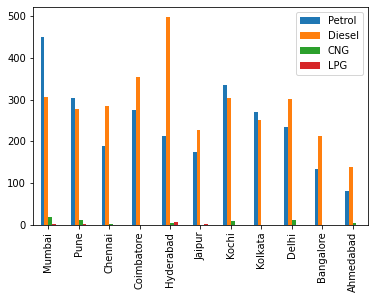

In [19]:
a = []
for i in dfToAnalyze['Location'].unique():
    a.append(dfToAnalyze[dfToAnalyze.Location == i].Fuel_Type.value_counts())
    
a = pd.DataFrame(a)
a.index = dfToAnalyze['Location'].unique()
a.plot.bar()


The usage of petrol is higher in Mumbai, Pune, Kochi, and Kolkata among the second hand vehicles.In other cities though, the usage of Diesel is higher

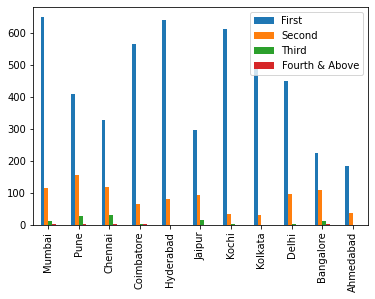

In [20]:
a = []
for i in dfToAnalyze['Location'].unique():
    a.append(dfToAnalyze[dfToAnalyze.Location == i].Owner_Type.value_counts())
    
a = pd.DataFrame(a)
a.index = dfToAnalyze['Location'].unique()
a.plot.bar()


First hand vehicles are more abundant in all cities, and show no specific variation with cities

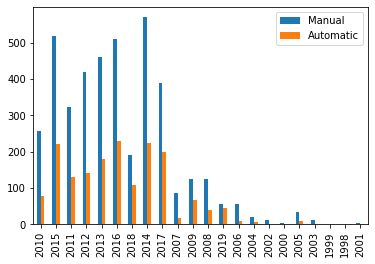

In [21]:
a = []
for i in dfToAnalyze['Year'].unique():
    a.append(dfToAnalyze[dfToAnalyze.Year == i].Transmission.value_counts())
    
a = pd.DataFrame(a)
a.index = dfToAnalyze['Year'].unique()
a.plot.bar()


The recent years show a huge surge in the number of vehicles on sale from that year of manufacture, which isn't surprising. The surge has occurred mostly beyond 2009

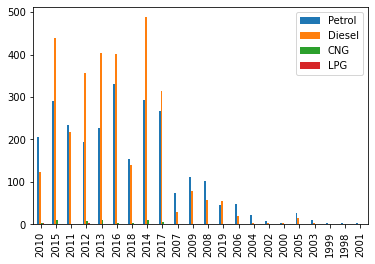

In [22]:
a = []
for i in dfToAnalyze['Year'].unique():
    a.append(dfToAnalyze[dfToAnalyze.Year == i].Fuel_Type.value_counts())
    
a = pd.DataFrame(a)
a.index = dfToAnalyze['Year'].unique()
a.plot.bar()


The cars manufactured beyond year 2010 show an increase in the usage of Diesel as a fuel, as compared to Petrol for the cars manufactured in previous years.


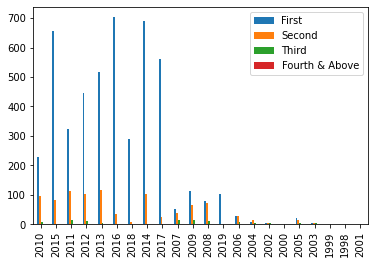

In [23]:
a = []
for i in dfToAnalyze['Year'].unique():
    a.append(dfToAnalyze[dfToAnalyze.Year == i].Owner_Type.value_counts())
    
a = pd.DataFrame(a)
a.index = dfToAnalyze['Year'].unique()
a.plot.bar()


Second hand cars are always more popular and in sale than the cars that have been used more than twice or more times. Also, beyond 2010, there is a sudden surge in the number of cars available that were manufactured during that period, which can be imputed to technological advancements.

**Univaraite analysis of continuous variables**

Before applying any model, it is necessary to check whether the continuous variables follow the assumptions of univariate model y = central tendency + error
where the error is random, vraiance remains same throughout, from a fixed distribution and with no correlation within the data. These assumptions would validate (or invalidate) the assumptions we make in future while building the models.

In [0]:
kilometersDriven = dfToAnalyze['Kilometers_Driven']
mileage = dfToAnalyze['Mileage']
engineVolume = dfToAnalyze['Engine']
power = dfToAnalyze['Power']
price = dfToAnalyze['Price']

In [0]:
# 1. Run Sequence plot, to check if the assumptions of univariate uncorrelated data remain valid

In [26]:
plt.plot(kilometersDriven, color = Blue)

NameError: ignored

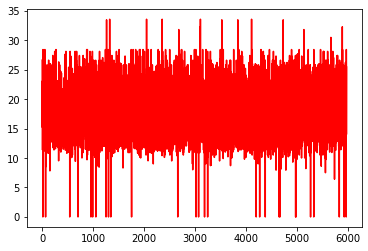

In [27]:
plt.plot(mileage, color = 'red')

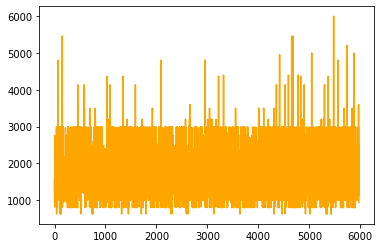

In [28]:
plt.plot(engineVolume, color = 'orange')

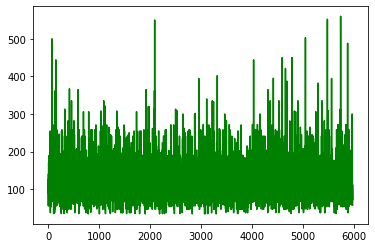

In [29]:
plt.plot(power, color = 'green')

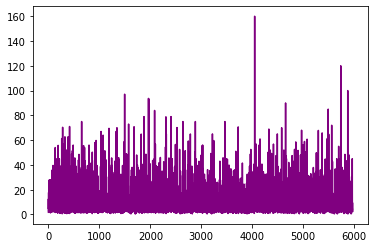

In [30]:
plt.plot(price, color = 'purple')

The data shows random variation about an unchanging mean throughout the span. The variation also remains nearly constant, with slight fluctuations. Also, the data shows presence of several outliers that need to be eliminated, before the data is used for training any model

In [0]:
# 2. Lag plot for checking correlation in data, if present. We plot yi as a function of yi-1

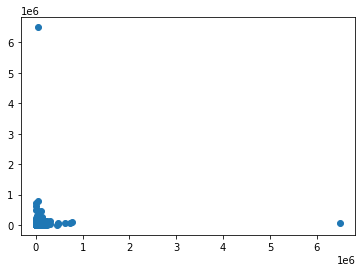

In [32]:
plt.scatter(np.insert(np.array(kilometersDriven)[:-1], 0, np.array(kilometersDriven)[-1], axis = 0), kilometersDriven)

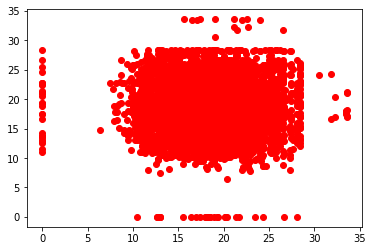

In [33]:
plt.scatter(np.insert(np.array(mileage)[:-1], 0, np.array(mileage)[-1], axis = 0), mileage, color = 'red')

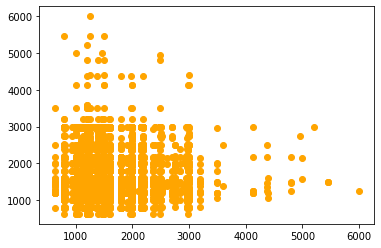

In [34]:
plt.scatter(np.insert(np.array(engineVolume)[:-1], 0, np.array(engineVolume)[-1], axis = 0), engineVolume, color = 'orange')

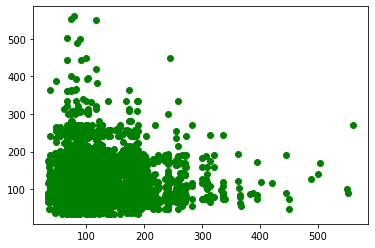

In [35]:
plt.scatter(np.insert(np.array(power)[:-1], 0, np.array(power)[-1], axis = 0), power, color = 'green')

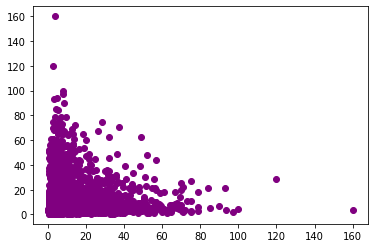

In [36]:
plt.scatter(np.insert(np.array(price)[:-1], 0, np.array(price)[-1], axis = 0), price, color = 'purple')

The data is clearly random, as it doesn't form a specified shape of structure. Thus there should be negligible autocorrelation in the data, which we check using Autocorrelation plots in the next section.

In [0]:
# 3. Autocorrelation plots, for checking if the data has any correlation, which should be absent as is evident from the previous analysis

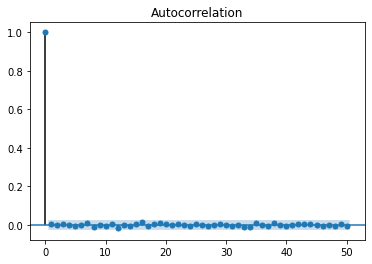

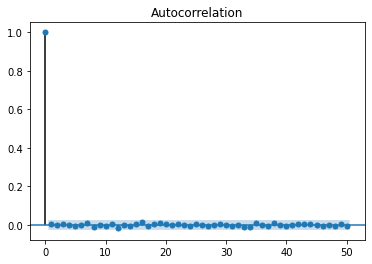

In [38]:
plot_acf(kilometersDriven, lags = 50)

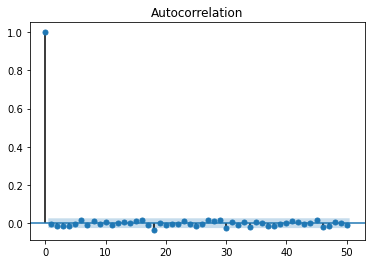

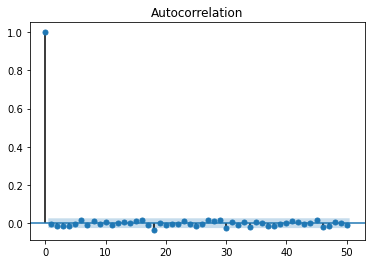

In [39]:
plot_acf(mileage, lags = 50)

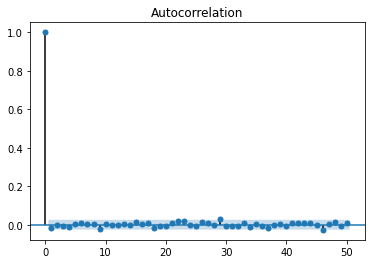

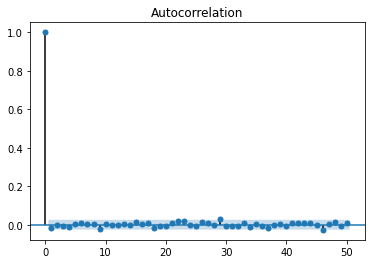

In [40]:
plot_acf(engineVolume, lags = 50)

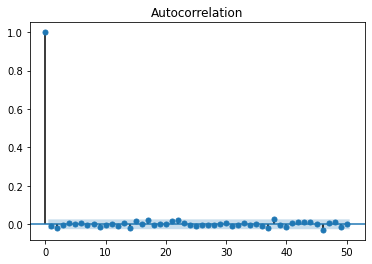

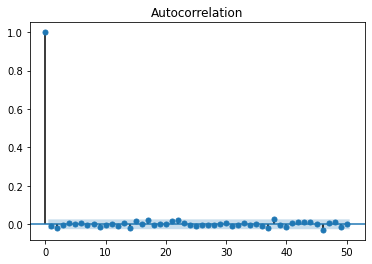

In [41]:
plot_acf(power, lags = 50)

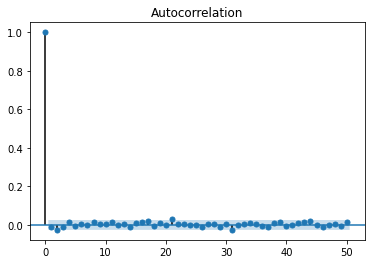

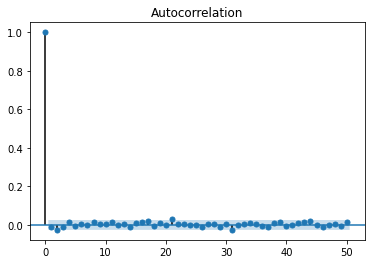

In [42]:
plot_acf(price, lags = 50)

Negligible autocorrelation even beyond the first step, as we had expected

In [0]:
# 4. Histograms, getting a sense of the univariate distribution

In [0]:

sns.set(color_codes = True)

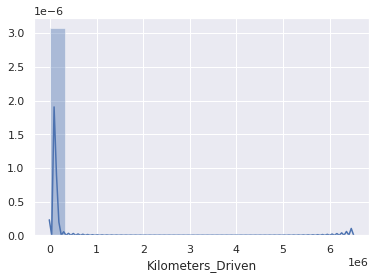

In [45]:
sns.distplot(kilometersDriven, bins = 20)

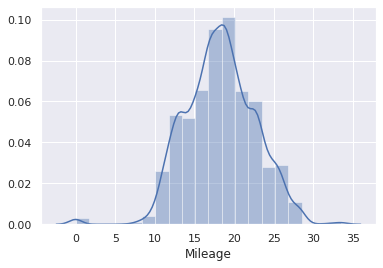

In [46]:
sns.distplot(mileage, bins = 20)

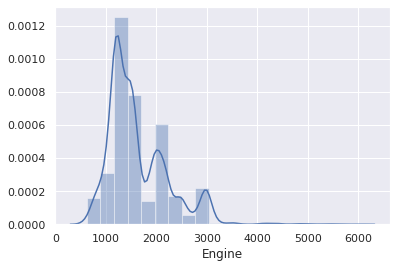

In [47]:
sns.distplot(engineVolume, bins = 20)

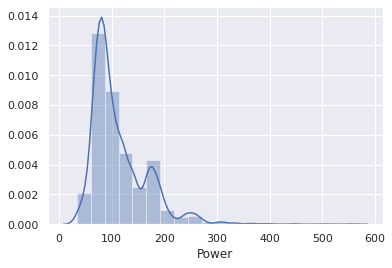

In [48]:
sns.distplot(power, bins = 20)

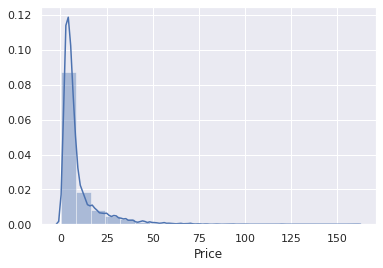

In [49]:
sns.distplot(price, bins = 20)

The distributions significantly deviate from the ideal normal distribution. There are some with a more number of peaks, small vraiation around the mean, and presence of tails around the data. The presence of tails is another reason to convince us of the presence of outliers which we should remove so that the model works best on the data.


In [0]:
# 4. Normal probability plot. To see whether a normal distribution explains the trends in the data, and if so, how well.

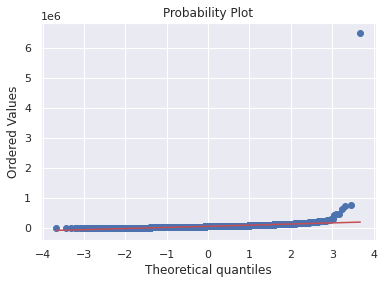

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
probplot(kilometersDriven, plot = ax)
plt.show()

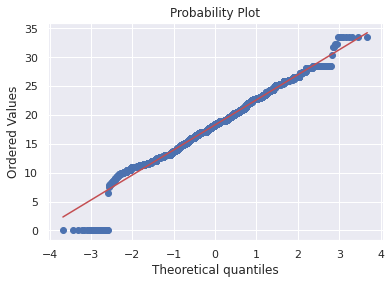

In [52]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
probplot(mileage, plot = ax)
plt.show()

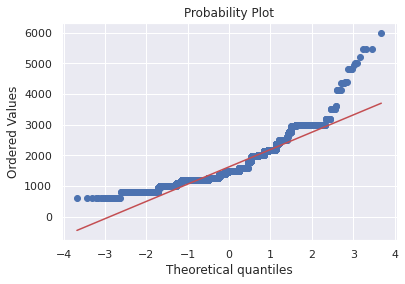

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
probplot(engineVolume, plot = ax)
plt.show()

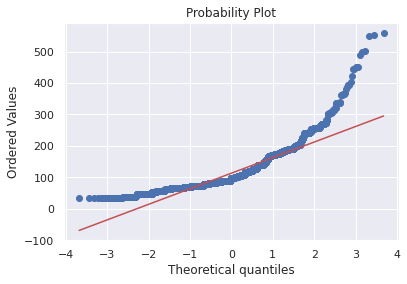

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
probplot(power, plot = ax)
plt.show()

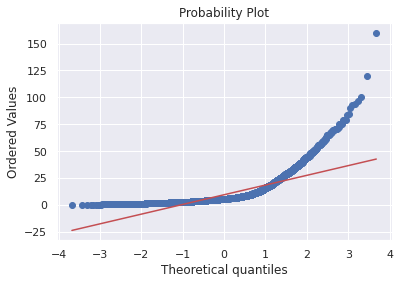

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
probplot(price, plot = ax)
plt.show()

There is a significant deviation from the normal distribution. This points to several complexities in the data that might not be captured by simple linear models and directs us to try more complex models for explaining the variation in the data

In [0]:
# 5. Uncertainty of statistics, median mean and midrange plots: Bootstrap plot

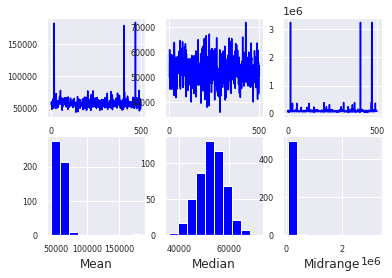

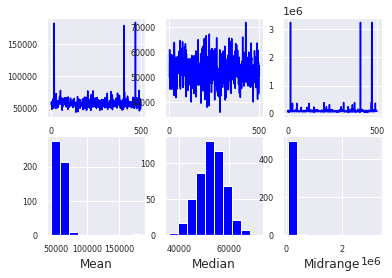

In [57]:
bootstrap_plot(kilometersDriven, samples = 500, color = 'blue')          #The median shows the greatest degree of variation, so it is the best estimate of central tendency

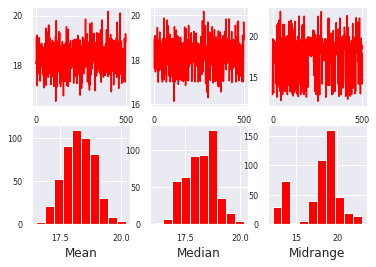

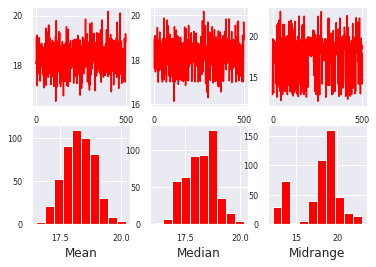

In [58]:
bootstrap_plot(mileage, samples = 500, color = 'red')   #The median and mean in this case capture the most variation

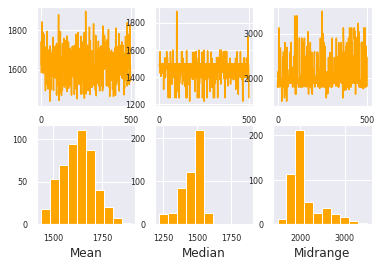

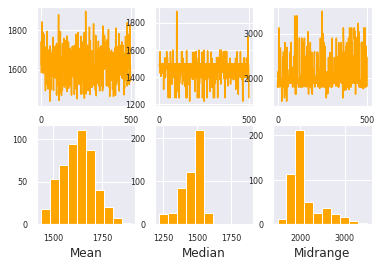

In [59]:
bootstrap_plot(engineVolume, samples = 500, color = 'orange') # The mean captures most of the variation of the data

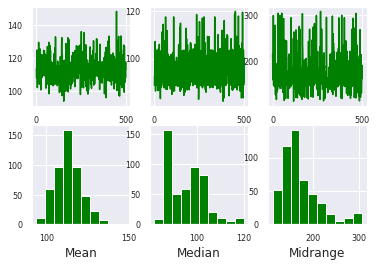

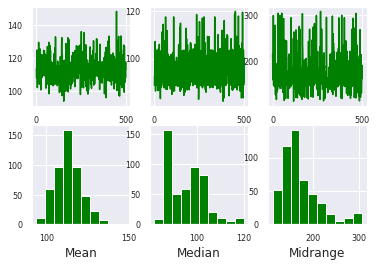

In [60]:
bootstrap_plot(power, samples = 500, color = 'green')  #The mean again, captures most of the variation in the data

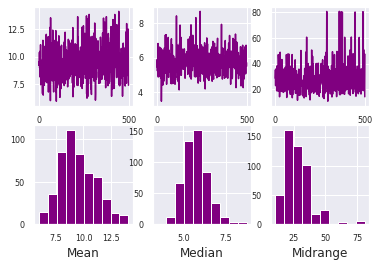

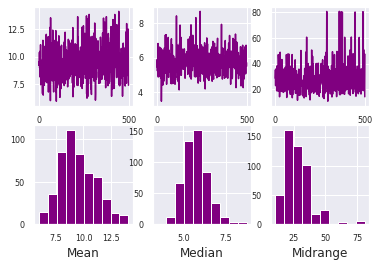

In [61]:
bootstrap_plot(price, samples = 500, color = 'purple')  # The mean in this case too, covers most of the variation in the data

The above plots show that there is no generalised estimate of the central tendency for the columns, which directs us to use more complex models while training the data.

**Outlier detection**

We shall now try to detect outliers in the continuous variables. 

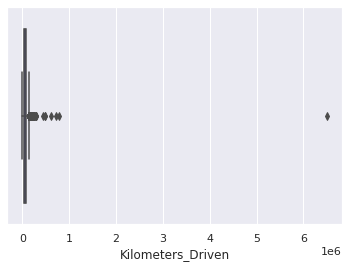

In [62]:
sns.boxplot(kilometersDriven,color='blue')               #Several outliers present, one too far off the mean.

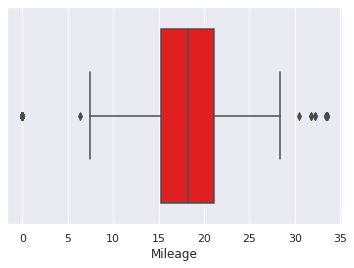

In [63]:
sns.boxplot(mileage,color='red')                   #Fewers outliers present, on both the ends, still present though, and need to be eliminated

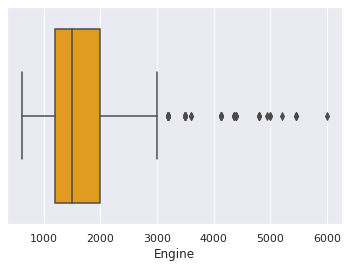

In [64]:
sns.boxplot(engineVolume,color='orange')                      # Several outliers present over one end of the data, basically presence of 

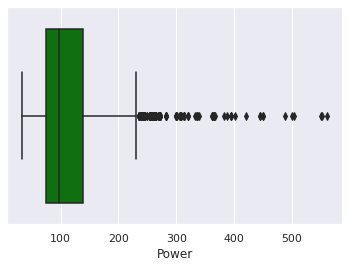

In [65]:
sns.boxplot(power,color='green')               #Several outliers present on one side, as in above, so they better be eliminated.

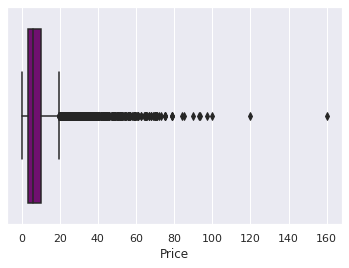

In [66]:
sns.boxplot(price,color='purple')        #Several outliers present, which should be eliminated, mostly on one end of the data

Several ouliers were detected in the continous variables which we shall remove for the purpose of getting a better fit in the model

**Dependence of target on different continuous variables**

We have four target variables, Kilometeres driven, engine, power and mileage. It would be interesting to check to what extent they depend on the continuous feature variables.

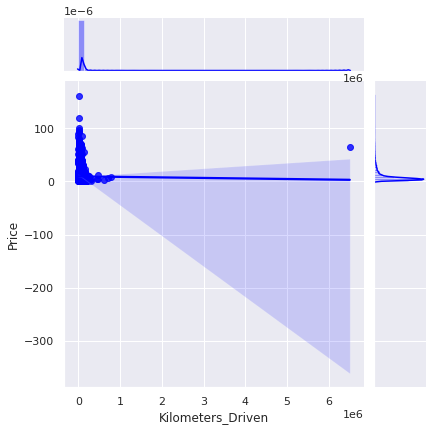

In [67]:
sns.jointplot("Kilometers_Driven", "Price", data=dfToAnalyze, kind='reg',color='blue')

Highly non-linear curve, data points are segregated on one side of the range, and thus a large outlier is present.

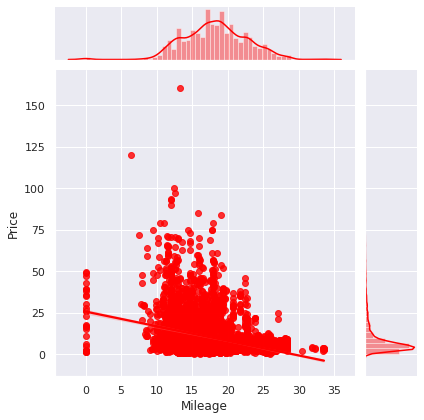

In [68]:
sns.jointplot("Mileage", "Price", data=dfToAnalyze, kind='reg',color='red')

The price is shown to decrease with an increase in mileage, which is a highly counterintuitive result. The use of a linear model can't capture most of the trends in data, and as we shall see later, linear models don't perform very well on the given data

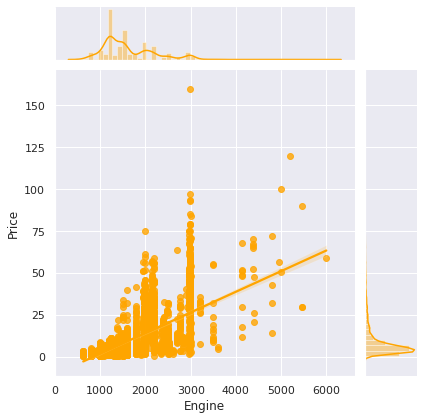

In [69]:
sns.jointplot("Engine", "Price", data=dfToAnalyze, kind='reg',color='orange')

With an increase in engine volume, the price of the car goes up, which is expected. Although, there are several outliers and much of the variation in the data isn't accounted for by a single linear model

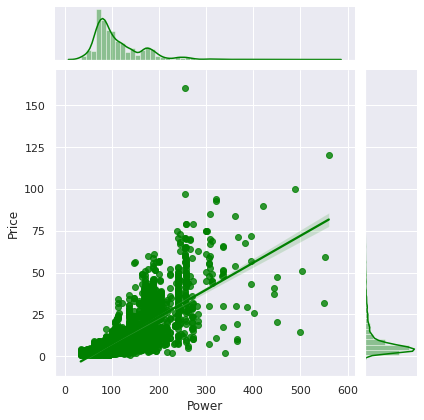

In [70]:
sns.jointplot("Power", "Price", data=dfToAnalyze, kind='reg',color='green')

The price goes up with the power of the vehicle, which is again expected. As before, there are several ouliers and data has a big variation about the linear model.

**Multivariate analysis**

Now we shall simply observe the variation of price across different continuous variables, and categorical variables to understand the underlying structure of the data.

Text(0.5, 1.0, 'Engine and Power with Fuel Type')

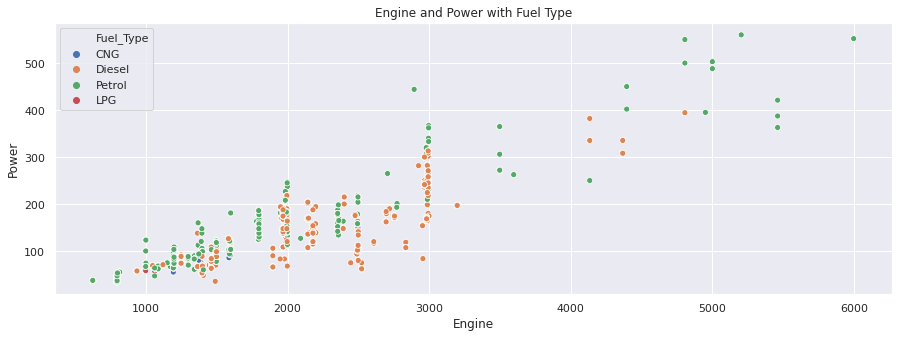

In [71]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Power', hue = 'Fuel_Type', 
           data = dfToAnalyze)
plt.title('Engine and Power with Fuel Type')

The power delivered by the engine increases with an increase in the engine capacity. This is a linear trend, and thus the price and power columns are expected to have a high corelation. While petrol automobiles are spread over the expanse of the power-engine capacity range, diesel autombiles are located towards the lower end of  power-engine capacity range. The rest might be treated as outliers.

Text(0.5, 1.0, 'Engine and Mileage with Fuel Type')

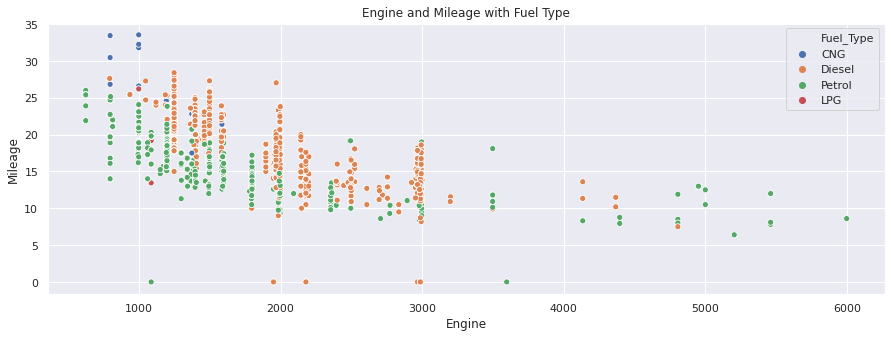

In [72]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Mileage', hue = 'Fuel_Type', 
           data = dfToAnalyze)
plt.title('Engine and Mileage with Fuel Type')

The mileage reduces with an increase in engine volume as a general trend, although a lot of variation is seen towards the lower end of the expanse. Irrespective of fuel type, the density of instances is higher towards the lower end of the mileage-engine capacity spectrum

Text(0.5, 1.0, 'Power and Mileage with Fuel Type')

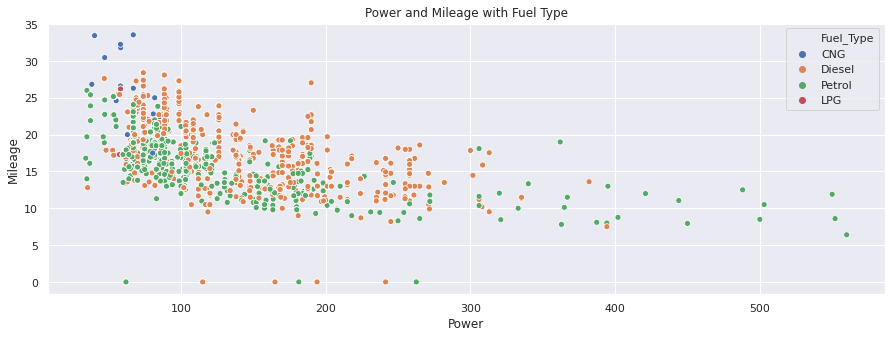

In [73]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Power', y = 'Mileage', hue = 'Fuel_Type', 
           data = dfToAnalyze)
plt.title('Power and Mileage with Fuel Type')

The mileage provided by the vehicle goes down slightly as the power increases. All fuel kinds are densely scattered towards the left side of the expanse, which suggests the presence of outliers.

Text(0.5, 1.0, 'Engine and Power with Year')

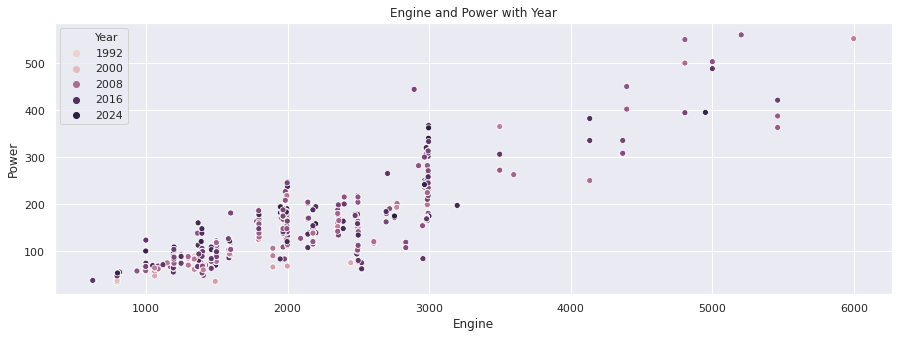

In [74]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Power', hue = 'Year', 
           data = dfToAnalyze)
plt.title('Engine and Power with Year')

The power of the vehicle has increased with an increase in engine volume, which isn't unexpected. These show a high corelation. The desnity increases with increase in the manufacturing year, which indicates improvement in automobile manufacture over the years.

Text(0.5, 1.0, 'Engine and Mileage with Year')

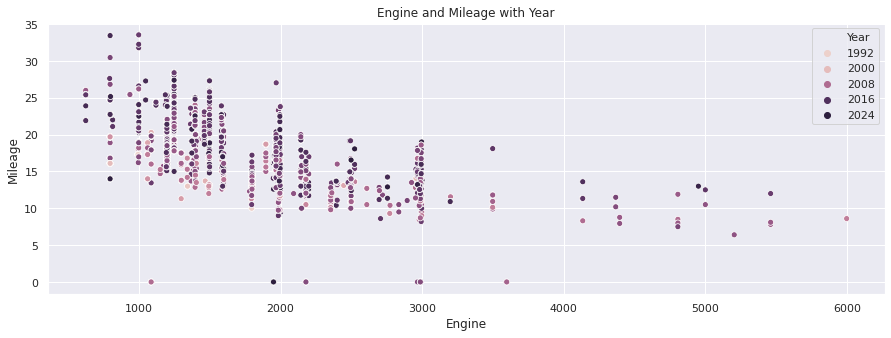

In [75]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Mileage', hue = 'Year', 
           data = dfToAnalyze)
plt.title('Engine and Mileage with Year')

The same trend as was discussed above is followed. Newly manufatured automobiles are concentrated towards the left end of the spectrum, which corresponds to increase in mileage of the vehicle with year.

Text(0.5, 1.0, 'Power and Mileage with Year')

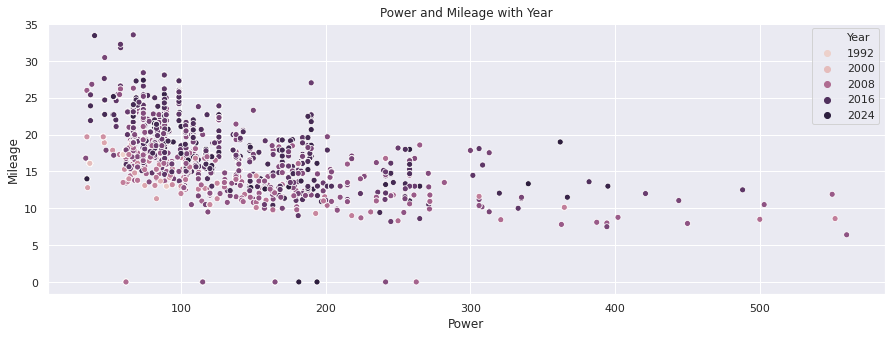

In [76]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Power', y = 'Mileage', hue = 'Year', 
           data = dfToAnalyze)
plt.title('Power and Mileage with Year')

The variation is the same as noted in above plots

Text(0.5, 1.0, 'Engine and Power with Transmission')

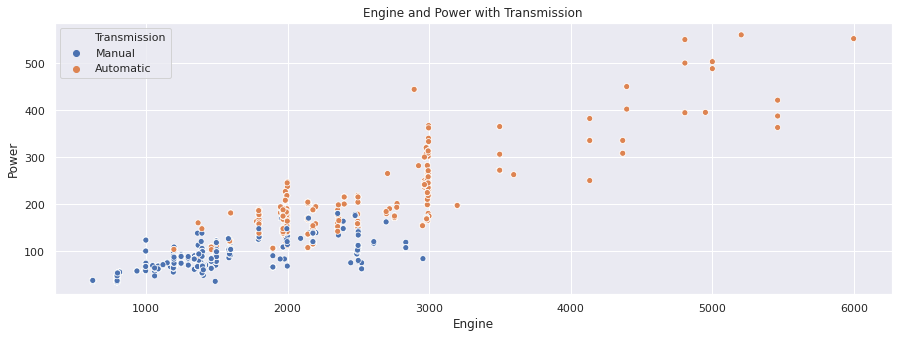

In [77]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Power', hue = 'Transmission', 
           data = dfToAnalyze)
plt.title('Engine and Power with Transmission')

The variation is the same as noted in a similar figure previously. Although, automatic transmission engines have a higher spread and are located higher in the plot.

Text(0.5, 1.0, 'Engine and Mileage with Transmission')

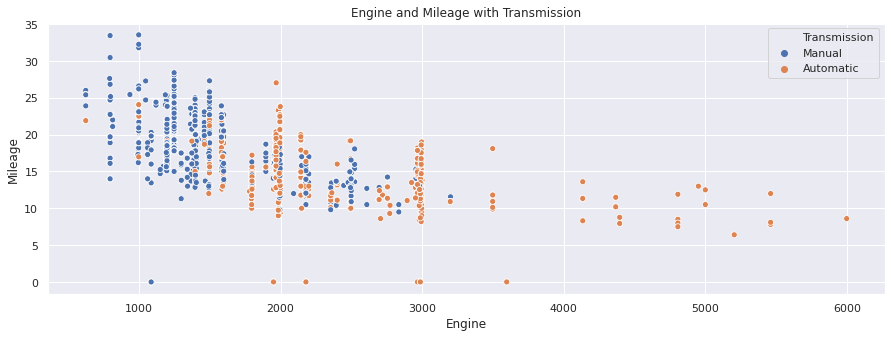

In [78]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Mileage', hue = 'Transmission', 
           data = dfToAnalyze)
plt.title('Engine and Mileage with Transmission')

The variation is similar as desribed in the previous few figures

Text(0.5, 1.0, 'Power and Mileage with Transmission')

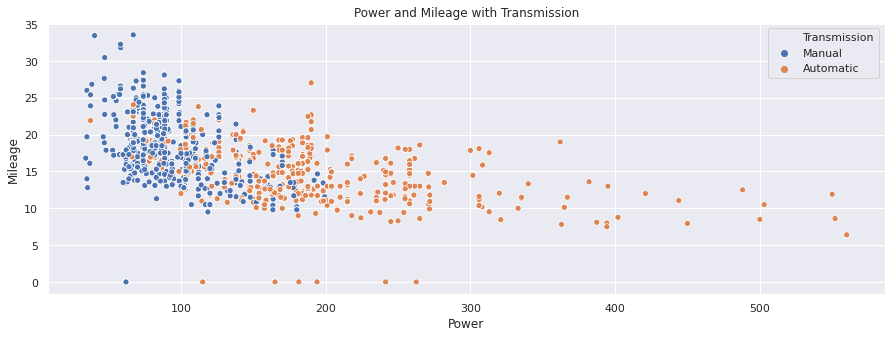

In [79]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Power', y = 'Mileage', hue = 'Transmission', 
           data = dfToAnalyze)
plt.title('Power and Mileage with Transmission')

The variation in quantities is same as noted in previous few figures.

Text(0.5, 1.0, 'Engine and Power with Owner_Type')

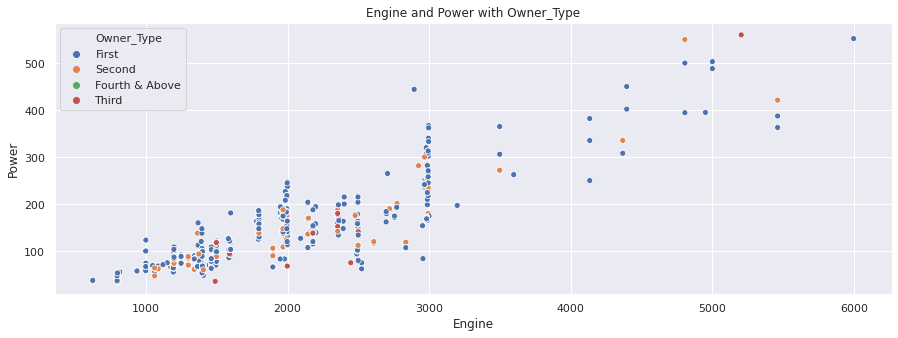

In [80]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Power', hue = 'Owner_Type', 
           data = dfToAnalyze)
plt.title('Engine and Power with Owner_Type')

The variation in power-engine capacity is the same as described before. The second hand vehicles show a higher spread which decreases with increase in ownership of the vehicle.

Text(0.5, 1.0, 'Engine and Mileage with Owner_Type')

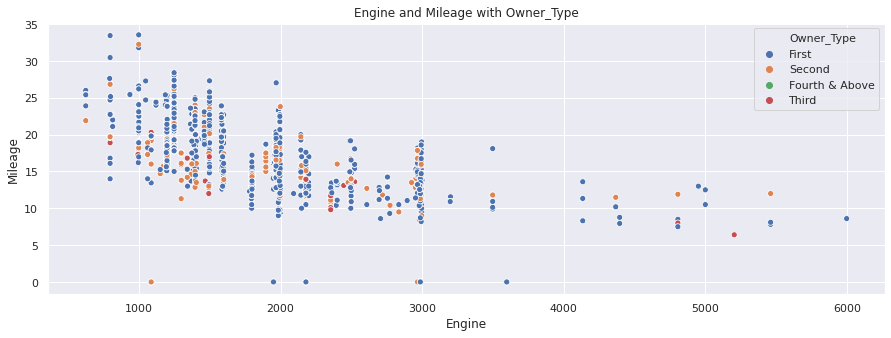

In [81]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Engine', y = 'Mileage', hue = 'Owner_Type', 
           data = dfToAnalyze)
plt.title('Engine and Mileage with Owner_Type')

The variation with the three variables is similar as has been described in the previous few plots.

Text(0.5, 1.0, 'Power and Mileage with Owner_Type')

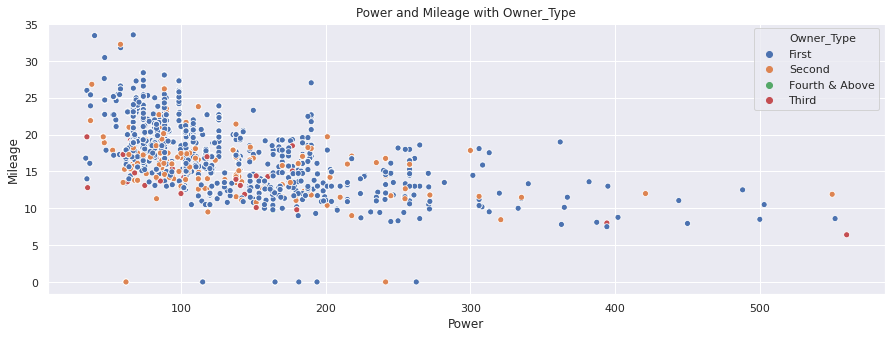

In [82]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'Power', y = 'Mileage', hue = 'Owner_Type', 
           data = dfToAnalyze)
plt.title('Power and Mileage with Owner_Type')

The variation in the three variables goes the same way as has been described in the previous few figures.

**Variation of feature with categorical variables**

Text(0, 0.5, 'Location')

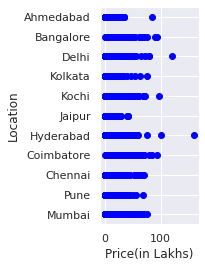

In [83]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.scatter(dfToAnalyze['Price'],dfToAnalyze['Location'],c='blue')
plt.xlabel('Price(in Lakhs)')
plt.ylabel('Location')

Highest variation of price is seen in Coimbatore (ignoring outliers), and the least variation in automobile prices is seen in Jaipur

Text(0.5, 0, 'Year')

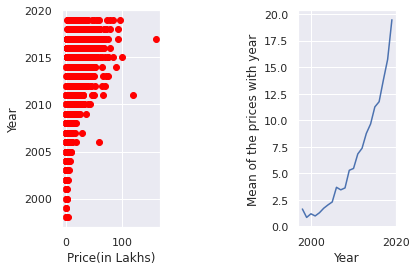

In [84]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.scatter(dfToAnalyze['Price'],dfToAnalyze['Year'],c='red')
plt.xlabel('Price(in Lakhs)')
plt.ylabel('Year')
plt.subplot(1,3,3)
plt.plot(dfToAnalyze.groupby('Year').Price.mean())
plt.ylabel('Mean of the prices with year')
plt.xlabel('Year')

The variation in prices of the autombiles increase with the year of manufacture. Also, the average prices are seen to increase with each year too.

Text(0.5, 0, 'Fuel Type')

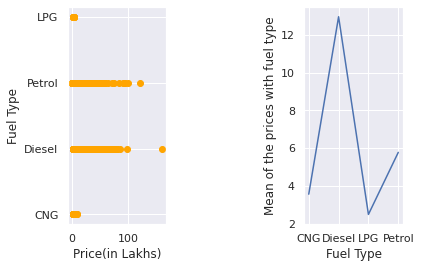

In [85]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.scatter(dfToAnalyze['Price'],dfToAnalyze['Fuel_Type'],c='orange')
plt.xlabel('Price(in Lakhs)')
plt.ylabel('Fuel Type')
plt.subplot(1,3,3)
plt.plot(dfToAnalyze.groupby('Fuel_Type').Price.mean())
plt.ylabel('Mean of the prices with fuel type')
plt.xlabel('Fuel Type')

Petrol and Diesel have the highest variation in the automobile price, as well as in the average prices. The contrary is valid for the other two.

Text(0.5, 0, 'Transmission type')

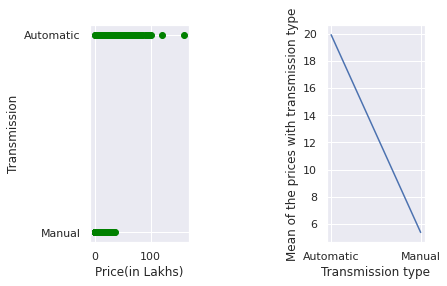

In [86]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.scatter(dfToAnalyze['Price'],dfToAnalyze['Transmission'],c='green')
plt.xlabel('Price(in Lakhs)')
plt.ylabel('Transmission')
plt.subplot(1,3,3)
plt.plot(dfToAnalyze.groupby('Transmission').Price.mean())
plt.ylabel('Mean of the prices with transmission type')
plt.xlabel('Transmission type')

Autoamtic transmission automobiles have higher variation in the prices as well as higher mean prices.

# **Data cleaning and feature extraction**

The column 'Name' contains test data which might be used in improving our model. We would need to process the data to render it useful for the model, all exploratory data analysis has been done before, and from this point on, we would focus solely on feature extraction to improve the performance of the models.

The first step required us to vectorise available data

In [87]:

textData = dfCombined['Name']
vectoriser = CountVectorizer()
textData = vectoriser.fit_transform(textData).toarray()
textData.shape

(7073, 783)

Now the no of columns in 'Name' is very high. That would unnecessarily increase the amount of data and computational capacity required for processing it and training the model over it. We would like to keep the no of features as low as possible and capture most of the variance in the data. Using principal component analysis, we can get an idea of how many columns would capture around 0.98 of the vatiation in the data. Then we would Truncated Singualar Value decomposition, a popular transform similar to PCA, applied for sparse matrices because of imaginary eigen values arising in case PCA is applied. It returns a matrix of the columns that capture 0.98 of the variation in the data

In [88]:

principalComponent = PCA(0.98)    #We can vary the parameter later, let's see how this works for the time bein
textDataModified = principalComponent.fit_transform(textData)
textDataModified.shape, textData.shape, principalComponent.n_components_

((7073, 382), (7073, 783), 382)

In [89]:
svDec = TruncatedSVD(n_components=principalComponent.n_components_, n_iter=10)

textDataTransformed = svDec.fit_transform(textData)
textDataTransformed.shape

(7073, 382)

In [90]:
# dfCombined.drop(['Name'], axis = 1, inplace = True)
textFeatures = pd.DataFrame(textDataTransformed)
textFeatures.isnull().any(), textFeatures.shape


textFeatures.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381
7068,0.059323,-0.027696,0.053101,0.313410,0.888294,-0.207245,0.944104,-0.039083,-0.042224,-0.095941,0.033568,0.000455,0.041612,0.174145,-0.012206,-0.048128,-0.001504,-0.009148,-0.017738,0.059963,-0.038547,0.075002,0.251489,0.081777,0.044108,-0.080428,0.003112,-0.049578,0.034221,-0.073510,-0.432668,-0.156862,-0.149900,0.100674,0.107622,0.052844,-0.095992,0.039507,0.027530,-0.209052,...,-0.004656,-0.001102,0.001890,0.006399,0.002471,-0.010042,-0.000325,0.005066,-0.003172,-0.005531,-0.005474,-0.001962,0.006507,0.002100,-0.006080,-0.003519,-0.000762,-0.010518,0.001987,-0.002046,0.005580,0.001010,-0.009616,0.009619,-0.003349,-0.003485,0.010214,0.007478,-0.003751,0.000882,0.009641,-0.012398,0.004253,0.011505,0.002039,0.002993,0.006142,0.007123,0.000879,-0.008525
7069,0.021962,-0.009785,0.037625,0.141674,0.430154,0.190136,0.892870,0.279143,-0.105271,-0.064138,-0.052334,-0.008134,-0.027732,-0.282093,0.038798,0.012760,0.091946,0.014095,0.037306,0.079299,0.013346,-0.056440,-0.095431,-0.046451,0.090256,0.026157,-0.038221,0.019123,-0.050795,0.102415,0.429692,-0.176104,-0.090496,-0.143102,-0.338498,-0.099943,0.058828,-0.020555,-0.035396,0.048357,...,-0.008477,0.002647,-0.001983,0.001051,0.005122,-0.007960,-0.001588,-0.006303,-0.016720,0.011266,0.002819,0.005893,-0.000299,-0.009075,-0.020690,0.006780,-0.005253,-0.004307,-0.006192,-0.002919,0.002234,-0.000708,0.002772,0.000444,-0.000307,0.001869,-0.006969,-0.008212,-0.002030,0.001750,-0.014093,0.001518,0.005042,-0.008574,-0.002345,-0.000743,-0.001741,-0.004203,-0.001089,-0.001893
7070,0.042350,-0.019981,0.023024,0.203977,0.535459,-0.409289,0.146491,-0.307061,0.066736,-0.026551,0.094698,0.007734,0.078945,0.547362,-0.071968,-0.054191,-0.007865,-0.006744,0.009311,0.237553,0.100972,0.184861,0.827606,-0.121343,0.533494,-0.593768,-0.079943,-0.244217,-0.323835,0.242128,0.102335,0.218552,0.091837,-0.322261,0.288964,0.094526,-0.055172,0.158098,-0.122322,0.061015,...,0.001659,0.007301,-0.002048,0.008910,0.004789,-0.013285,0.001593,0.000575,0.010198,0.003762,-0.000069,-0.004251,0.005022,0.009664,-0.009662,-0.002460,0.002347,-0.002643,0.002774,-0.003820,0.006923,0.004864,-0.002176,0.002707,0.004220,0.002524,-0.003968,-0.000205,-0.001880,0.001367,-0.003021,0.005508,-0.002005,-0.002981,-0.006124,0.000536,-0.003292,-0.000297,0.002404,0.000205
7071,0.021962,-0.009785,0.037625,0.141674,0.430154,0.190136,0.892870,0.279143,-0.105271,-0.064138,-0.052334,-0.008134,-0.027732,-0.282093,0.038798,0.012760,0.091946,0.014095,0.037306,0.079299,0.013346,-0.056440,-0.095431,-0.046451,0.090256,0.026157,-0.038221,0.019123,-0.050795,0.102415,0.429692,-0.176104,-0.090496,-0.143102,-0.338498,-0.099943,0.058828,-0.020555,-0.035396,0.048357,...,-0.008477,0.002647,-0.001983,0.001051,0.005122,-0.007960,-0.001588,-0.006303,-0.016720,0.011266,0.002819,0.005893,-0.000299,-0.009075,-0.020690,0.006780,-0.005253,-0.004307,-0.006192,-0.002919,0.002234,-0.000708,0.002772,0.000444,-0.000307,0.001869,-0.006969,-0.008212,-0.002030,0.001750,-0.014093,0.001518,0.005042,-0.008574,-0.002345,-0.000743,-0.001741,-0.004203,-0.001089,-0.001893
7072,0.048865,-0.021535,2.191200,-0.291612,-0.119355,-0.102064,0.084030,-0.155005,-0.025842,0.019928,0.010405,0.001087,0.013772,-0.056893,0.011222,-0.009548,0.013762,-0.011846,-0.031435,-0.002820,-0.051940,-0.015059,0.026279,-0.012729,0.000773,-0.009558,0.011069,0.032034,-0.022287,0.014579,-0.115645,0.128982,0.058324,0.251356,-0.243624,0.034320,-0.208118,0.402750,-0.215842,0.079132,...,0.001672,-0.046510,0.033367,0.057520,0.017295,-0.043010,-0.009583,0.040189,-0.013315,-0.003818,-0.009767,-0.021529,-0.036273,0.012573,-0.002602,0.025569,0.002094,-0.013709,0.008456,-0.004390,0.001923,-0.005633,0.016218,-0.031714,-0.000844,0.005282,-0.000893,

In [91]:
dfCombined.shape, textFeatures.isnull().any(), textFeatures.shape, dfCombined.isnull().any()

((7073, 13), 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 377    False
 378    False
 379    False
 380    False
 381    False
 Length: 382, dtype: bool, (7073, 382), index                False
 Name                 False
 Location             False
 Year                 False
 Kilometers_Driven    False
 Fuel_Type            False
 Transmission         False
 Owner_Type           False
 Mileage              False
 Engine               False
 Power                False
 Seats                False
 Price                False
 dtype: bool)

The textFeatures matrix returned by TruncatedSVD is appended as a feature to the dataframe, while the name column (which it was derived from) is simply dropped out.



In [92]:
dfCombined.reset_index(drop = True, inplace = True)
textFeatures.reset_index(drop = True, inplace = True)
dfCombinedModified = pd.concat([dfCombined, textFeatures], axis = 1)
dfCombinedModified.tail()

,index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381
7068,1229,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54,1598.0,103.6,5.0,100000000.0,0.059323,-0.027696,0.053101,0.313410,0.888294,-0.207245,0.944104,-0.039083,-0.042224,-0.095941,0.033568,0.000455,0.041612,0.174145,-0.012206,-0.048128,-0.001504,-0.009148,-0.017738,0.059963,-0.038547,0.075002,0.251489,0.081777,0.044108,-0.080428,0.003112,...,-0.004656,-0.001102,0.001890,0.006399,0.002471,-0.010042,-0.000325,0.005066,-0.003172,-0.005531,-0.005474,-0.001962,0.006507,0.002100,-0.006080,-0.003519,-0.000762,-0.010518,0.001987,-0.002046,0.005580,0.001010,-0.009616,0.009619,-0.003349,-0.003485,0.010214,0.007478,-0.003751,0.000882,0.009641,-0.012398,0.004253,0.011505,0.002039,0.002993,0.006142,0.007123,0.000879,-0.008525
7069,1230,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21,1197.0,103.6,5.0,100000000.0,0.021962,-0.009785,0.037625,0.141674,0.430154,0.190136,0.892870,0.279143,-0.105271,-0.064138,-0.052334,-0.008134,-0.027732,-0.282093,0.038798,0.012760,0.091946,0.014095,0.037306,0.079299,0.013346,-0.056440,-0.095431,-0.046451,0.090256,0.026157,-0.038221,...,-0.008477,0.002647,-0.001983,0.001051,0.005122,-0.007960,-0.001588,-0.006303,-0.016720,0.011266,0.002819,0.005893,-0.000299,-0.009075,-0.020690,0.006780,-0.005253,-0.004307,-0.006192,-0.002919,0.002234,-0.000708,0.002772,0.000444,-0.000307,0.001869,-0.006969,-0.008212,-0.002030,0.001750,-0.014093,0.001518,0.005042,-0.008574,-0.002345,-0.000743,-0.001741,-0.004203,-0.001089,-0.001893
7070,1231,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08,1461.0,63.1,5.0,100000000.0,0.042350,-0.019981,0.023024,0.203977,0.535459,-0.409289,0.146491,-0.307061,0.066736,-0.026551,0.094698,0.007734,0.078945,0.547362,-0.071968,-0.054191,-0.007865,-0.006744,0.009311,0.237553,0.100972,0.184861,0.827606,-0.121343,0.533494,-0.593768,-0.079943,...,0.001659,0.007301,-0.002048,0.008910,0.004789,-0.013285,0.001593,0.000575,0.010198,0.003762,-0.000069,-0.004251,0.005022,0.009664,-0.009662,-0.002460,0.002347,-0.002643,0.002774,-0.003820,0.006923,0.004864,-0.002176,0.002707,0.004220,0.002524,-0.003968,-0.000205,-0.001880,0.001367,-0.003021,0.005508,-0.002005,-0.002981,-0.006124,0.000536,-0.003292,-0.000297,0.002404,0.000205
7071,1232,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.20,1197.0,103.6,5.0,100000000.0,0.021962,-0.009785,0.037625,0.141674,0.430154,0.190136,0.892870,0.279143,-0.105271,-0.064138,-0.052334,-0.008134,-0.027732,-0.282093,0.038798,0.012760,0.091946,0.014095,0.037306,0.079299,0.013346,-0.056440,-0.095431,-0.046451,0.090256,0.026157,-0.038221,...,-0.008477,0.002647,-0.001983,0.001051,0.005122,-0.007960,-0.001588,-0.006303,-0.016720,0.011266,0.002819,0.005893,-0.000299,-0.009075,-0.020690,0.006780,-0.005253,-0.004307,-0.006192,-0.002919,0.002234,-0.000708,0.002772,0.000444,-0.000307,0.001869,-0.006969,-0.008212,-0.002030,0.001750,-0.014093,0.001518,0.005042,-0.008574,-0.002345,-0.000743,-0.001741,-0.004203,-0.001089,-0.001893
7072,1233,Mercedes-Benz E-Class 2009-2013 E 220 CDI Avan...,Kochi,2014,72443,Diesel,Automatic,First,10.00,2148.0,170.0,5.0,100000000.0,0.048865,-0.021535,2.191200,-0.291612,-0.119355,-0.102064,0.084030,-0.155005,-0.025842,0.019928,0.010405,0.001087,0.013772,-0.056893,0.011222,-0.009548,0.013762,-0.011846,-0.031435,-0.002820,-0.051940,-0.015059,0.026279,-0.012729,0.000773,-0.009558,0.011069,...,0.001672,-0.046510,0.033367,0.057520,0.017295,-0.043010,-0.009583,0.040189,-0.013315,-0.003818,-0.009767,-0.021529,-0.036273,0.012573,-0.002602,0.025569,0.002094,-0.013709,0.008456,-0.004390,0.001923,-0.005633,0.016218,-0.031714,-0.000844,0.005282,-0.00

In [93]:
dfCombinedModified.isnull().any()

index                False
Name                 False
Location             False
Year                 False
Kilometers_Driven    False
                     ...  
377                  False
378                  False
379                  False
380                  False
381                  False
Length: 395, dtype: bool

We do one hot encoding for all the categorical variables so that they can be fed into the model.

In [0]:
mEnc = pd.get_dummies(dfCombinedModified, columns = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])

In [95]:
mEnc.head()

,index,Name,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,0,Maruti Wagon R LXI CNG,2010,72000,26.60,998.0,58.16,5.0,1.75,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,1,Hyundai Creta 1.6 CRDi SX Option,2015,41000,19.67,1582.0,126.20,5.0,12.50,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2,Honda Jazz V,2011,46000,18.20,1199.0,88.70,5.0,4.50,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,3,Maruti Ertiga VDI,2012,87000,20.77,1248.0,88.76,7.0,6.00,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,4,Audi A4 New 2.0 TDI Multitronic,2013,40670,15.20,1968.0,140.80,5.0,17.74,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [0]:
mEnc = mEnc.drop(['Name'], axis = 1)

In [97]:
mEnc.shape
mEnc.head()

,index,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,0,2010,72000,26.60,998.0,58.16,5.0,1.75,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,-0.054021,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,1,2015,41000,19.67,1582.0,126.20,5.0,12.50,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,0.148572,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,0.021499,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,0.296060,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,-0.273522,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


Exploratory data analysis revealed the presence of several outliers in the continuous variables, we can remove them from the training data. This would improve the performance of whatever model we would be applying over the data. Also, note that this isn't done over the test data, because that would invariably mean not performing prediction on the model even though all the features are present.

In [98]:

rEncTest = mEnc[mEnc['Price']==1e8]
rEncTrain = mEnc[mEnc['Price']!= 1e8]
rEncTrain.shape, rEncTest.shape  #Note that the columns having a null value 'Power' column have been removed from the test set

((5872, 411), (1201, 411))

In [99]:
rEncTrain.head()

,index,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,0,2010,72000,26.60,998.0,58.16,5.0,1.75,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,-0.054021,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,1,2015,41000,19.67,1582.0,126.20,5.0,12.50,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,0.148572,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,0.021499,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,0.296060,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,-0.273522,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [100]:

rEncTrain.drop(['index'], axis = 1, inplace = True)
rEncTrain.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5.0,1.75,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,-0.054021,-0.010931,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,12.50,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,0.148572,-0.179835,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,0.021499,-0.037239,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,0.296060,-0.458643,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,-0.273522,-0.084881,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [101]:
rEncTest.head()

,index,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
5872,0,2014,40929,32.26,998.0,58.20,4.0,100000000.0,0.733473,0.922887,-0.019576,-0.039562,-0.038017,-0.023497,0.020818,-0.024098,0.005241,0.007224,-0.017461,-0.973963,0.140736,-0.059902,-0.152297,-0.144534,-0.062291,0.642235,-0.208240,-0.083237,0.030816,-0.363158,0.217998,-0.316933,0.081002,0.021446,0.041129,0.146296,0.256012,-0.189010,0.040657,0.010292,...,0.019791,-0.008016,0.004897,0.031408,0.016965,-0.000284,-0.005621,-0.018893,-0.018242,0.015311,0.000881,0.002121,-0.008243,-0.014772,0.002004,0.007948,-0.024656,0.037714,0.014037,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
5873,1,2013,54493,24.70,796.0,47.30,5.0,100000000.0,0.743025,0.938128,-0.018404,-0.035473,-0.035981,-0.024858,0.020723,-0.028551,0.041165,0.020542,-0.027127,-1.063430,0.169739,-0.082202,-0.186252,-0.180263,-0.089582,0.877325,-0.278432,-0.108270,0.042148,-0.494062,0.321471,-0.441541,0.130657,0.028902,0.078266,0.254007,0.435567,-0.373756,0.089033,0.038055,...,-0.014452,-0.000871,0.003306,-0.015593,-0.009697,0.002458,-0.002186,0.014926,0.005143,-0.002451,0.001395,0.007433,0.007258,0.000467,-0.002447,0.005140,0.007612,-0.002383,-0.002854,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5874,2,2017,34000,13.68,2393.0,147.80,7.0,100000000.0,0.053776,-0.007275,0.136632,0.618321,0.484280,-0.597102,-0.553855,-0.057484,-0.086234,0.169756,-0.224148,0.026471,-0.187939,-0.957632,-0.070795,-0.108675,0.560626,-0.045241,-0.025861,-0.083977,0.148219,0.050121,-0.009047,0.008760,-0.195474,-0.051837,0.053085,-0.031744,0.184821,-0.131364,0.125355,0.129118,...,-0.002690,-0.038075,0.005790,-0.001034,0.003795,0.044595,0.014841,-0.037125,-0.013846,0.010532,0.007031,0.004363,-0.046867,0.027303,-0.017548,-0.026591,-0.014566,-0.037597,-0.018240,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
5875,4,2014,29000,18.50,1197.0,82.85,5.0,100000000.0,0.883249,-0.728040,-0.067672,-0.126587,-0.095462,-0.057618,0.085077,-0.223054,-0.026330,0.004305,-0.182163,-0.001595,0.020459,-0.107206,-0.526957,0.726246,-0.037673,-0.006519,-0.023429,0.020154,0.013076,-0.388454,0.122640,0.442265,-0.049339,-0.027065,-0.257706,0.171081,-0.128312,-0.034087,0.025787,0.001355,...,-0.001410,0.001489,-0.000410,-0.000167,-0.001185,-0.000992,0.000597,0.000077,-0.001656,0.001946,-0.000484,0.001577,-0.000047,-0.003366,-0.002078,-0.001392,-0.000548,0.002824,0.004538,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
5876,5,2016,85609,16.00,2179.0,140.00,7.0,100000000.0,0.010535,-0.001787,0.008815,0.031344,0.032126,-0.002338,-0.084148,0.149018,-0.001350,0.007209,0.047036,0.296732,1.718647,-0.235202,-0.078315,-0.073435,0.006622,0.011360,-0.067811,0.012442,-0.000136,0.023588,-0.048853,-0.020656,0.109781,0.047207,-0.073462,0.065720,-0.057342,0.011491,-0.071791,-0.094234,...,-0.003852,0.001614,-0.000362,-0.003319,-0.000713,0.000291,-0.002548,0.001662,-0.002305,0.000732,0.000968,-0.001008,0.000128,-0.000102,-0.001081,-0.000545,-0.000182,-0.002446,-0.001920,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


The Z score tells us how much a feature is away from the mean of the dataset. A Z score of 3 for instance, would represent that the datapoint is 3 standard deviations away from the mean of the data. We ignore the entries with a Z score greater than 3 as outliers in the data.

In [102]:
zScore = np.abs(stats.zscore(rEncTrain['Kilometers_Driven']))
R = rEncTrain[zScore < 3]
# R.info()
zScore = np.abs(stats.zscore(R['Mileage']))
R = R[zScore < 3]
# R.info()
zScore = np.abs(stats.zscore(R['Engine']))
R = R[zScore < 3]
# R.info()
zScore = np.abs(stats.zscore(R['Power']))
R = R[zScore < 3]
zScore = np.abs(stats.zscore(R['Price']))
R = R[zScore < 3]
R.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 5871
Columns: 410 entries, Year to Owner_Type_Third
dtypes: float64(387), int64(2), uint8(21)
memory usage: 16.8 MB


In [103]:
R.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5.0,1.75,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,-0.054021,-0.010931,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,12.50,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,0.148572,-0.179835,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,0.021499,-0.037239,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,0.296060,-0.458643,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,-0.273522,-0.084881,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [104]:
R.reset_index(inplace = True, drop = True)
R.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5.0,1.75,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,-0.054021,-0.010931,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,12.50,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,0.148572,-0.179835,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,0.021499,-0.037239,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,0.296060,-0.458643,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,-0.273522,-0.084881,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [105]:
y = R.iloc[:, 6]
X = R.drop(['Price'], axis = 1)
X.shape, y.shape

((5592, 409), (5592,))

In [106]:
#Normalising the columns and storing the value in a list, for normalising the test set
X.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5.0,0.708541,0.890538,-0.018754,-0.037542,-0.032304,-0.025059,0.015544,-0.026683,-0.001775,0.003649,-0.012526,-0.828587,0.122986,-0.055219,-0.103254,-0.103396,-0.064771,0.498974,0.004301,-0.054139,-0.007069,-0.095247,-0.089855,0.089250,-0.263665,-0.042261,0.053194,-0.407002,-0.284328,0.485423,-0.124337,-0.054021,-0.010931,-0.018832,...,0.024094,-0.000423,-0.004714,0.020727,0.015099,-0.014908,-0.000901,-0.003688,-0.004336,0.004915,0.001707,0.007689,-0.013673,0.002075,-0.001403,0.015763,0.001679,0.002891,-0.017366,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,1.093638,-0.878000,-0.067181,-0.063036,-0.082576,-0.033883,0.025142,-0.086480,0.042733,-0.018091,1.001436,0.017810,-0.082744,-0.173702,-0.087461,-0.396849,-0.004963,0.025653,0.048615,0.006277,-0.019929,0.389881,-0.185517,-0.293009,0.234229,0.063040,0.093483,0.051658,0.548830,0.533648,-0.100148,0.148572,-0.179835,0.164903,...,-0.002467,0.000805,0.002994,-0.000178,-0.001510,0.001820,-0.000066,-0.003146,0.003269,-0.001967,0.003086,0.002165,0.004611,0.001916,0.001184,-0.000654,-0.000567,0.000810,-0.000266,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,0.026274,-0.010671,0.068353,0.741663,-0.367577,0.041758,0.089598,-0.109392,-0.140111,-0.023232,0.029665,-0.003229,0.021679,0.108248,0.041416,0.031115,-0.140545,0.006544,-0.025020,0.017521,-0.000837,-0.028596,0.012177,0.005358,-0.051482,-0.010249,0.135770,0.264931,-0.129643,0.101892,-0.073871,0.021499,-0.037239,-0.061385,...,0.010862,-0.007954,-0.010553,-0.010133,-0.009450,0.006883,0.005244,0.007217,0.003937,-0.006363,-0.005477,0.006983,-0.000123,-0.000794,0.005078,-0.006079,0.009225,0.002335,-0.006805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,0.673084,0.847322,-0.018042,-0.039804,-0.038418,-0.010015,0.027317,-0.035060,-0.019858,-0.004816,-0.006133,0.247314,-0.055685,-0.009880,0.061539,0.045326,0.039169,0.316430,-0.009404,-0.023077,-0.002678,0.477782,-0.108560,0.342924,0.124177,-0.020870,-0.194021,0.190595,-0.186605,-0.193778,0.203454,0.296060,-0.458643,0.211300,...,-0.002392,0.000722,-0.000917,-0.001400,-0.000301,0.001238,0.000873,0.000283,-0.000748,0.001000,-0.000198,0.000418,-0.000334,-0.000748,0.000148,0.000616,-0.001475,0.000225,-0.001892,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,0.042945,-0.012174,0.242124,0.150505,0.563613,1.026138,-0.379735,-0.451421,-0.105800,-0.042393,-0.134606,0.012663,-0.027783,0.000993,-0.314532,-0.281956,-0.183131,-0.011021,-0.032557,-0.066464,-0.002489,0.090506,-0.138737,0.058240,-0.055324,0.102370,-0.093456,0.092464,-0.029446,-0.026227,0.085842,-0.273522,-0.084881,-0.343110,...,-0.004169,0.005909,-0.002970,0.002116,0.002097,-0.003086,-0.003583,0.004564,0.003446,-0.004982,0.000151,0.000428,0.000406,0.004135,0.004159,0.001869,-0.002406,-0.005937,-0.007708,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


For training a model over some dataset, it really speeds up the training process if one normalises the data. We normalise the data and _leak_ the *mean* and *standard deviation* for the columns, to be used for normalising the test data before using the model to make predictions over it

In [0]:
def featureScaling(dataFrame):
  cache = []
  for column in dataFrame:
    cache.append([np.mean(dataFrame[column]), np.std(dataFrame[column])])
    dataFrame[column] = (dataFrame[column] - np.mean(dataFrame[column]))/np.std(dataFrame[column])
  return cache

In [0]:
cache = featureScaling(X) #Storing the values

In [109]:
rEncTest.head()

,index,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
5872,0,2014,40929,32.26,998.0,58.20,4.0,100000000.0,0.733473,0.922887,-0.019576,-0.039562,-0.038017,-0.023497,0.020818,-0.024098,0.005241,0.007224,-0.017461,-0.973963,0.140736,-0.059902,-0.152297,-0.144534,-0.062291,0.642235,-0.208240,-0.083237,0.030816,-0.363158,0.217998,-0.316933,0.081002,0.021446,0.041129,0.146296,0.256012,-0.189010,0.040657,0.010292,...,0.019791,-0.008016,0.004897,0.031408,0.016965,-0.000284,-0.005621,-0.018893,-0.018242,0.015311,0.000881,0.002121,-0.008243,-0.014772,0.002004,0.007948,-0.024656,0.037714,0.014037,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
5873,1,2013,54493,24.70,796.0,47.30,5.0,100000000.0,0.743025,0.938128,-0.018404,-0.035473,-0.035981,-0.024858,0.020723,-0.028551,0.041165,0.020542,-0.027127,-1.063430,0.169739,-0.082202,-0.186252,-0.180263,-0.089582,0.877325,-0.278432,-0.108270,0.042148,-0.494062,0.321471,-0.441541,0.130657,0.028902,0.078266,0.254007,0.435567,-0.373756,0.089033,0.038055,...,-0.014452,-0.000871,0.003306,-0.015593,-0.009697,0.002458,-0.002186,0.014926,0.005143,-0.002451,0.001395,0.007433,0.007258,0.000467,-0.002447,0.005140,0.007612,-0.002383,-0.002854,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5874,2,2017,34000,13.68,2393.0,147.80,7.0,100000000.0,0.053776,-0.007275,0.136632,0.618321,0.484280,-0.597102,-0.553855,-0.057484,-0.086234,0.169756,-0.224148,0.026471,-0.187939,-0.957632,-0.070795,-0.108675,0.560626,-0.045241,-0.025861,-0.083977,0.148219,0.050121,-0.009047,0.008760,-0.195474,-0.051837,0.053085,-0.031744,0.184821,-0.131364,0.125355,0.129118,...,-0.002690,-0.038075,0.005790,-0.001034,0.003795,0.044595,0.014841,-0.037125,-0.013846,0.010532,0.007031,0.004363,-0.046867,0.027303,-0.017548,-0.026591,-0.014566,-0.037597,-0.018240,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
5875,4,2014,29000,18.50,1197.0,82.85,5.0,100000000.0,0.883249,-0.728040,-0.067672,-0.126587,-0.095462,-0.057618,0.085077,-0.223054,-0.026330,0.004305,-0.182163,-0.001595,0.020459,-0.107206,-0.526957,0.726246,-0.037673,-0.006519,-0.023429,0.020154,0.013076,-0.388454,0.122640,0.442265,-0.049339,-0.027065,-0.257706,0.171081,-0.128312,-0.034087,0.025787,0.001355,...,-0.001410,0.001489,-0.000410,-0.000167,-0.001185,-0.000992,0.000597,0.000077,-0.001656,0.001946,-0.000484,0.001577,-0.000047,-0.003366,-0.002078,-0.001392,-0.000548,0.002824,0.004538,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
5876,5,2016,85609,16.00,2179.0,140.00,7.0,100000000.0,0.010535,-0.001787,0.008815,0.031344,0.032126,-0.002338,-0.084148,0.149018,-0.001350,0.007209,0.047036,0.296732,1.718647,-0.235202,-0.078315,-0.073435,0.006622,0.011360,-0.067811,0.012442,-0.000136,0.023588,-0.048853,-0.020656,0.109781,0.047207,-0.073462,0.065720,-0.057342,0.011491,-0.071791,-0.094234,...,-0.003852,0.001614,-0.000362,-0.003319,-0.000713,0.000291,-0.002548,0.001662,-0.002305,0.000732,0.000968,-0.001008,0.000128,-0.000102,-0.001081,-0.000545,-0.000182,-0.002446,-0.001920,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


The test feature variables are normalised using the _cache_ _leaked_ from the train data set. Also, the index column is redundant, so it's dropped, and can be used to identify a given test entry while making predictions using the model.

In [0]:
def testFeatureScaling(dataFrame, cache):
  dataFrame = np.array(dataFrame)
  dataFrame = (dataFrame - np.array(cache).T[0, :])/(np.array(cache).T[1, :])
  return pd.DataFrame(dataFrame)


In [111]:
index = rEncTest['index']
rEncTest.drop(['index', 'Price'], axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [112]:
np.array(cache).shape, rEncTest.shape

((409, 2), (1201, 409))

In [113]:
testDataCleaned = testFeatureScaling(rEncTest, cache)
testDataCleaned.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408
0,0.183260,-0.488744,3.375796,-1.097144,-1.149022,-1.640704,0.939395,1.681764,-0.327323,-0.585378,-0.365127,-0.084155,0.014058,-0.054544,-0.045531,-0.155572,-0.037815,-3.622536,0.326393,-0.208721,-0.609250,-0.618106,-0.264841,2.896410,-1.131301,-0.323451,0.175931,-1.873545,1.169291,-1.652817,0.342763,0.021025,0.283517,0.766517,1.531563,-1.081763,0.206997,-0.022905,-0.726572,-0.125642,...,0.723433,-0.283043,0.191621,1.319462,0.733968,-0.005860,-0.225318,-0.859613,-0.759248,0.720526,0.043686,0.088637,-0.319592,-0.628515,0.061074,0.325850,-1.005766,1.584888,0.589408,-0.200928,-0.245142,-0.299743,-0.33459,3.126430,-0.373937,-0.276816,-0.350237,-0.315418,-0.389618,-0.339197,11.495341,-1.054033,-0.042326,-0.931188,-0.590567,0.590567,0.464099,-0.035403,-0.433901,-0.133558
1,-0.133033,-0.086267,1.518533,-1.485758,-1.405668,-0.370306,0.963574,1.710574,-0.324294,-0.574380,-0.359614,-0.088033,0.013761,-0.068745,0.071882,-0.106987,-0.071233,-3.954112,0.433373,-0.292763,-0.750039,-0.770399,-0.385017,3.964236,-1.465505,-0.444265,0.260248,-2.551936,1.714917,-2.313275,0.609221,0.062058,0.486441,1.359932,2.535199,-2.112644,0.485745,0.140677,-0.364012,0.322502,...,-0.515130,-0.024276,0.126765,-0.647342,-0.406166,0.106408,-0.092789,0.692817,0.210769,-0.138317,0.063944,0.295926,0.263474,0.012911,-0.106452,0.211386,0.303570,-0.088998,-0.115280,-0.200928,-0.245142,-0.299743,2.98873,-0.319854,-0.373937,-0.276816,-0.350237,-0.315418,-0.389618,-0.339197,-0.086992,-1.054033,-0.042326,1.073897,-0.590567,0.590567,-2.154712,-0.035403,2.304672,-0.133558
2,1.132141,-0.694344,-1.188748,1.586602,0.960655,2.170490,-0.781143,-0.076555,0.076482,1.184211,1.049234,-1.719484,-1.779210,-0.161013,-0.344512,0.437322,-0.752414,0.085201,-0.885914,-3.591861,-0.271311,-0.465256,2.478147,-0.226252,-0.262934,-0.327022,1.049494,0.268209,-0.027943,0.073438,-1.140849,-0.382286,0.348846,-0.214361,1.133636,-0.760098,0.695039,0.677242,0.890590,-0.697477,...,-0.089691,-1.371748,0.228023,-0.038091,0.170807,1.831081,0.564182,-1.696540,-0.576889,0.489435,0.286112,0.176104,-1.772450,1.142444,-0.674761,-1.081769,-0.596330,-1.559010,-0.757183,-0.200928,-0.245142,-0.299743,-0.33459,-0.319854,-0.373937,-0.276816,-0.350237,-0.315418,2.566616,-0.339197,-0.086992,0.948737,-0.042326,-0.931188,-0.590567,0.590567,0.464099,-0.035403,-0.433901,-0.133558
3,0.183260,-0.842707,-0.004619,-0.714301,-0.568625,-0.370306,1.318529,-1.439043,-0.451653,-0.819460,-0.520687,-0.181432,0.214578,-0.689023,-0.148721,-0.166218,-0.607255,-0.018813,-0.117244,-0.386990,-2.162738,3.093561,-0.156435,-0.050371,-0.251354,0.175529,0.043934,-2.004638,0.666456,2.371126,-0.356665,-0.245957,-1.349391,0.903066,-0.616652,-0.217294,0.121314,-0.075562,0.285110,-0.161515,...,-0.043415,0.061213,-0.024730,-0.001827,-0.042189,-0.034811,0.014613,0.011211,-0.071257,0.074287,-0.010136,0.067391,-0.011310,-0.148409,-0.092567,-0.054782,-0.027524,0.128394,0.193119,-0.200928,-0.245142,-0.299743,-0.33459,-0.319854,-0.373937,-0.276816,-0.350237,-0.315418,2.566616,-0.339197,-0.086992,-1.054033,-0.042326,1.073897,-0.590567,0.590567,0.464099,-0.035403,-0.433901,-0.133558
4,0.815847,0.837021,-0.618794,1.174902,0.777000,2.170490,-0.890601,-0.066181,-0.253932,-0.394654,-0.175181,-0.023829,-0.313488,0.497531,-0.067076,-0.155626,0.185179,1.086823,6.146472,-0.869349,-0.302488,-0.315047,0.038616,0.030843,-0.462671,0.138310,-0.054374,0.130707,-0.237845,-0.082473,0.497196,0.162800,-0.342634,0.322596,-0.219957,0.037036,-0.440947,-0.638798,-0.138187,-0.610300,...,-0.131740,0.065729,-0.022789,-0.133741,-0.021984,0.017676,-0.106738,0.083944,-0.098189,0.015620,0.047106,-0.033495,-0.004714,-0.011036,-0.055027,-0.020286,-0.012678,-0.091628,-0.076309,-0.200928,-0.245142,-0.299743,2.98873,-0.31

In [114]:
rEncTest.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
5872,2014,40929,32.26,998.0,58.20,4.0,0.733473,0.922887,-0.019576,-0.039562,-0.038017,-0.023497,0.020818,-0.024098,0.005241,0.007224,-0.017461,-0.973963,0.140736,-0.059902,-0.152297,-0.144534,-0.062291,0.642235,-0.208240,-0.083237,0.030816,-0.363158,0.217998,-0.316933,0.081002,0.021446,0.041129,0.146296,0.256012,-0.189010,0.040657,0.010292,-0.114082,-0.032482,...,0.019791,-0.008016,0.004897,0.031408,0.016965,-0.000284,-0.005621,-0.018893,-0.018242,0.015311,0.000881,0.002121,-0.008243,-0.014772,0.002004,0.007948,-0.024656,0.037714,0.014037,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
5873,2013,54493,24.70,796.0,47.30,5.0,0.743025,0.938128,-0.018404,-0.035473,-0.035981,-0.024858,0.020723,-0.028551,0.041165,0.020542,-0.027127,-1.063430,0.169739,-0.082202,-0.186252,-0.180263,-0.089582,0.877325,-0.278432,-0.108270,0.042148,-0.494062,0.321471,-0.441541,0.130657,0.028902,0.078266,0.254007,0.435567,-0.373756,0.089033,0.038055,-0.052563,0.040853,...,-0.014452,-0.000871,0.003306,-0.015593,-0.009697,0.002458,-0.002186,0.014926,0.005143,-0.002451,0.001395,0.007433,0.007258,0.000467,-0.002447,0.005140,0.007612,-0.002383,-0.002854,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5874,2017,34000,13.68,2393.0,147.80,7.0,0.053776,-0.007275,0.136632,0.618321,0.484280,-0.597102,-0.553855,-0.057484,-0.086234,0.169756,-0.224148,0.026471,-0.187939,-0.957632,-0.070795,-0.108675,0.560626,-0.045241,-0.025861,-0.083977,0.148219,0.050121,-0.009047,0.008760,-0.195474,-0.051837,0.053085,-0.031744,0.184821,-0.131364,0.125355,0.129118,0.160316,-0.126057,...,-0.002690,-0.038075,0.005790,-0.001034,0.003795,0.044595,0.014841,-0.037125,-0.013846,0.010532,0.007031,0.004363,-0.046867,0.027303,-0.017548,-0.026591,-0.014566,-0.037597,-0.018240,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
5875,2014,29000,18.50,1197.0,82.85,5.0,0.883249,-0.728040,-0.067672,-0.126587,-0.095462,-0.057618,0.085077,-0.223054,-0.026330,0.004305,-0.182163,-0.001595,0.020459,-0.107206,-0.526957,0.726246,-0.037673,-0.006519,-0.023429,0.020154,0.013076,-0.388454,0.122640,0.442265,-0.049339,-0.027065,-0.257706,0.171081,-0.128312,-0.034087,0.025787,0.001355,0.057579,-0.038352,...,-0.001410,0.001489,-0.000410,-0.000167,-0.001185,-0.000992,0.000597,0.000077,-0.001656,0.001946,-0.000484,0.001577,-0.000047,-0.003366,-0.002078,-0.001392,-0.000548,0.002824,0.004538,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
5876,2016,85609,16.00,2179.0,140.00,7.0,0.010535,-0.001787,0.008815,0.031344,0.032126,-0.002338,-0.084148,0.149018,-0.001350,0.007209,0.047036,0.296732,1.718647,-0.235202,-0.078315,-0.073435,0.006622,0.011360,-0.067811,0.012442,-0.000136,0.023588,-0.048853,-0.020656,0.109781,0.047207,-0.073462,0.065720,-0.057342,0.011491,-0.071791,-0.094234,-0.014246,-0.111791,...,-0.003852,0.001614,-0.000362,-0.003319,-0.000713,0.000291,-0.002548,0.001662,-0.002305,0.000732,0.000968,-0.001008,0.000128,-0.000102,-0.001081,-0.000545,-0.000182,-0.002446,-0.001920,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


We check for null values, in the training data set (X,y) and proceed to build and train our model.

In [115]:
X.isnull().any(), testDataCleaned.isnull().any(), y.isnull().any()

(Year                         False
 Kilometers_Driven            False
 Mileage                      False
 Engine                       False
 Power                        False
                              ...  
 Transmission_Manual          False
 Owner_Type_First             False
 Owner_Type_Fourth & Above    False
 Owner_Type_Second            False
 Owner_Type_Third             False
 Length: 409, dtype: bool, 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 404    False
 405    False
 406    False
 407    False
 408    False
 Length: 409, dtype: bool, False)

## **Model selection**


Splitting the data into an appropriate ratio of 3:1 for train:test

In [116]:

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25)
XTrain.shape, XTest.shape, yTrain.shape, yTest.shape

((4194, 409), (1398, 409), (4194,), (1398,))

**Linear regression model**

The trends as we concluded can't be explained well based on a simple linear model. But it would be a good point to observe its performance on the given dataset, and improve over it successively with better models.

In [117]:
#Making the linear regression model
model2 = LinearRegression()
model2.fit(XTrain, yTrain)
yPred = model2.predict(XTest)
r2_score(yTest, yPred)

0.7873638432248826

**Polynomial regression**

The linear model didn't perform really well on the given dataset. So, we transform the feature variables into  fourth degree polynomial features, and then fit a linear model to it, in short, do polynomiual regression.

In [0]:
# polyReg = PolynomialFeatures(degree = 3)
# XPoly = polyReg.fit_transform(XTrain)
# model3 = LinearRegression()
# model3.fit(XPoly, yTrain)
# yPred = model3.predict(polyReg.transform(XTest))
# r2_score(yTest, yPred)

Given the high dimensionality of the data, it's difficlut to train a polynomial model over the given data, the runtime crashes due to exceeding required RAM. So we try other approaches.

**Decision Tree regressor**

We use a decision tree having a large number of estimators to fit the given data, and observe its performance over the given dataset.

In [118]:
model4 = DecisionTreeRegressor(random_state = 0)
model4.fit(XTrain, yTrain)
yPred = model4.predict(XTest)
r2_score(yTest, yPred)

0.8271333727154508

**Random forest regression**

We apply random forest regression, an ensemble learning technique that 

In [0]:
# model5 = RandomForestRegressor(n_estimators = 500, random_state = 0)
# model5.fit(XTrain, yTrain)
# yPred = model5.predict(XTest)
# r2_score(yTest, yTred)

Random forest regression suffers the same problem as polynomial regression models. Due to high dimensionality of data, we fail to train the model over an ensemble of decision trees.

**The deep neural network model**

We do hyperparameter tuning and settle over the no of layers and no. of nodes in each layer, which reduces the mean squared error over the training dataset. We use a validation ratio of 0.1 for testing the validation accuracy and its accuracy over the course of training. With appropriate tuning we end up with a model that performs well.

In [126]:

model1 = Sequential()
model1.add(Dense(512, input_dim = XTrain.shape[1], kernel_initializer='normal', activation = 'relu', kernel_regularizer=l2(0.01)))
model1.add(Dense(256, kernel_initializer='normal', activation = 'relu', kernel_regularizer=l2(0.01)))
model1.add(Dense(256, kernel_initializer='normal', activation = 'relu', kernel_regularizer=l2(0.01)))
model1.add(Dense(256, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer=l2(0.01)))
model1.add(Dense(1, kernel_initializer='normal', activation='linear'))
opt = keras.optimizers.Adam(learning_rate = 5e-4)
model1.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['mean_squared_error', 'mean_absolute_error'])
model1.summary()
history = model1.fit(XTrain, yTrain, epochs= 400 , batch_size= 256 ,  verbose=1, validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               209920    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 473,089
Trainable params: 473,089
Non-trainable params: 0
_________________________________________________________________
Train on 3774 samples, validate on 420 samples
Epoch 1/400
3774/3774 [==============================] - 1s 143us/s

In [127]:
yPred = model1.predict(XTrain)
yPredTest = model1.predict(XTest)
r2_score(yTrain, yPred), r2_score(yTest, yPredTest)

(0.9896317457427724, 0.9343525223319157)

A lot of the models couldn't be trained due to the size of the data and RAM limitations. Those have been commented out.

# **Predicting for the test dataset**

For identifying each entry of the test data set, post the dropping of null values, we stored them in an index variable, so we shall load it and concatenate it with the prediction for the model, and present the results. The neural network model provided the best r_2 score among others, so we shall deploy it for the purpose of this project.

In [128]:
index.shape, rEncTest.shape

((1201,), (1201, 409))

In [140]:
predictedPrices = model1.predict(rEncTest)

predictedPrices = np.array(predictedPrices)
predictedPrices.shape

(1201, 1)

In [0]:
index = np.array(index)
index
index = index.reshape((1201,1))

In [0]:
output = np.concatenate([index, predictedPrices])       #The output for the model

In [144]:
np.min(predictedPrices)

4125.867

In [145]:
np.max(predictedPrices)

22880.912